In [5]:
import tensorflow as tf 
import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


**Loading the data form *drive* with tf pipline**



In [6]:
data=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Potato disease/Data',batch_size=32,
                                                      image_size=(256,256),
                                                     shuffle=True)

Found 2152 files belonging to 3 classes.


In [7]:
labels=data.class_names
labels

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for i , l in data.take(1):
    print('shape',i.shape)
    print('label',l.numpy())
    

shape (32, 256, 256, 3)
label [1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 2 1 1 1 0 1 1 0 0 2 2 1]


**ploting some images to see the data**

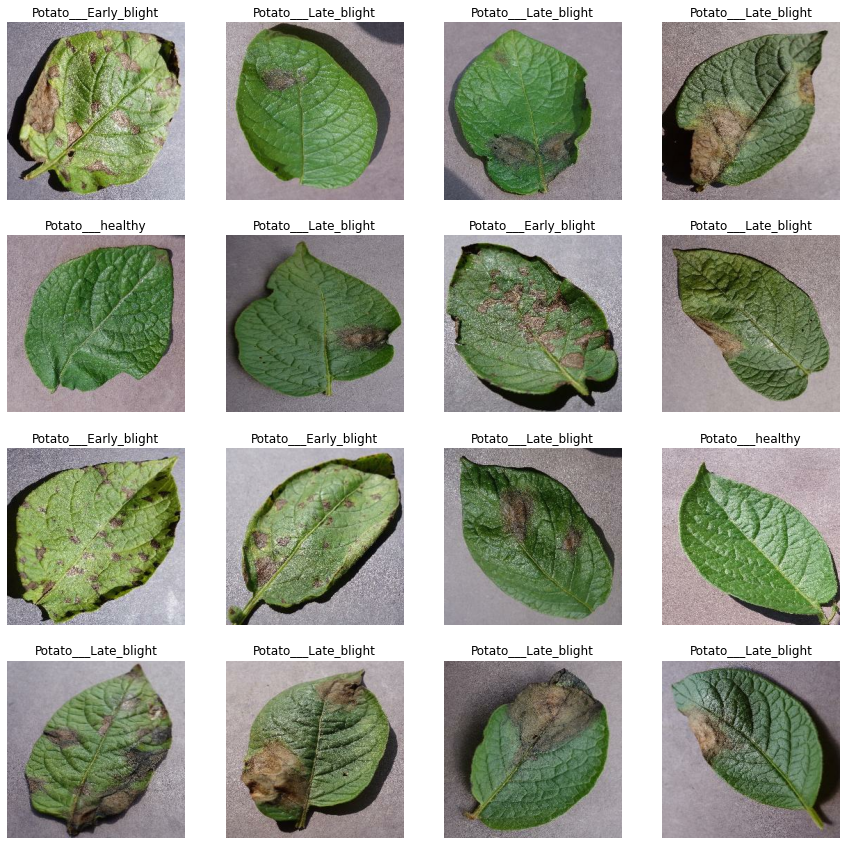

In [9]:
plt.figure(figsize=(15, 15))
for image , label in data.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(labels[label[i]])
        plt.axis('off')

**spliting the data in in to Train(.8),Test(.1) and valid(.1)**

In [10]:
def spliting(ds,training_size=.8,testing_size=.1,val_size=.1,shuffle=True,shuffle_s=10000):
    assert (training_size+testing_size+val_size)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_s, seed=12)
    train_size=int(ds_size * training_size)
    val_size=int(ds_size * val_size)
    train_set=ds.take(train_size)
    val=ds.skip(train_size).take(val_size)
    test_set=ds.skip(train_size).skip(val_size)
    return train_set,test_set,val

In [11]:
train_set,test_set,val=spliting(data)

In [12]:
len(train_set)

54

In [13]:
len(test_set)

8

In [14]:
len(val)

6

**set the data in cache and doing prefetch that will imporve the running time** 

In [15]:
train_set=train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set=test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val=val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **preprocessing the data**

**make sure all images have same size and scale it from 0 to 1**  

In [16]:
# we will use this layers later in our final model
scale_resize=keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0,255)
])

**doing some data augmentation to make our model more rubost**

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
 
])

# **buliding Model**

In [18]:
Model=models.Sequential([
    scale_resize,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])
Model.build(input_shape=(32,256,256,3))

In [19]:
Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [20]:
Model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**fiting the model in test_set**

In [22]:
history=Model.fit(
    train_set,
    batch_size=32,
    validation_data=val,
    verbose=1,
    epochs=50
)

Epoch 1/50
54/54 [==============================] - 13s 240ms/step - loss: 2.3358 - accuracy: 0.4832 - val_loss: 0.8608 - val_accuracy: 0.4844
Epoch 2/50
54/54 [==============================] - 7s 136ms/step - loss: 0.8307 - accuracy: 0.6111 - val_loss: 0.8406 - val_accuracy: 0.6094
Epoch 3/50
54/54 [==============================] - 7s 136ms/step - loss: 0.7678 - accuracy: 0.6464 - val_loss: 0.7132 - val_accuracy: 0.6823
Epoch 4/50
54/54 [==============================] - 7s 136ms/step - loss: 0.7721 - accuracy: 0.6470 - val_loss: 0.9080 - val_accuracy: 0.6354
Epoch 5/50
54/54 [==============================] - 7s 137ms/step - loss: 0.7017 - accuracy: 0.7049 - val_loss: 0.7457 - val_accuracy: 0.6667
Epoch 6/50
54/54 [==============================] - 7s 135ms/step - loss: 0.7066 - accuracy: 0.6968 - val_loss: 0.9031 - val_accuracy: 0.6458
Epoch 7/50
54/54 [==============================] - 7s 135ms/step - loss: 0.6425 - accuracy: 0.7280 - val_loss: 0.5339 - val_accuracy: 0.7604
Epoch

In [23]:
score= Model.evaluate(test_set)

8/8 [==============================] - 5s 52ms/step - loss: 0.0355 - accuracy: 0.9883


In [24]:
loss=score[0]
acc=score[1]
loss,acc

(0.035493526607751846, 0.98828125)

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
acc=history.history['accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
val_accuracy=history.history['val_accuracy']


# **ploting Accuracy and Loss Vs the epochs to see if the data need more training epochs or not** 

Text(0.5, 1.0, 'Training and Validation loss')

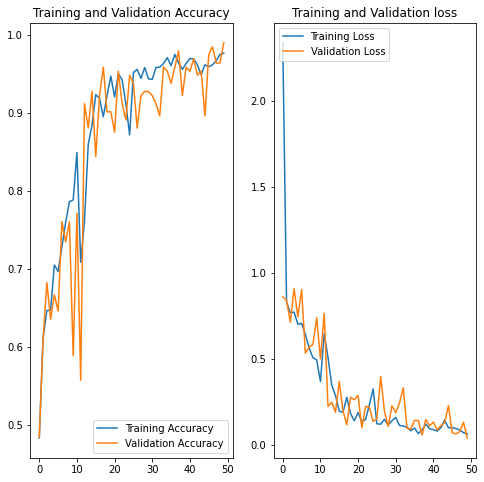

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation loss')


**Accuracy is good now we save the our model**

In [32]:
Model.save('potato_dis.h5')

# **now we plot some images with there predicted labels and how confident the  model is from the result**

In [36]:
import numpy as np
labels=data.class_names
labels
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

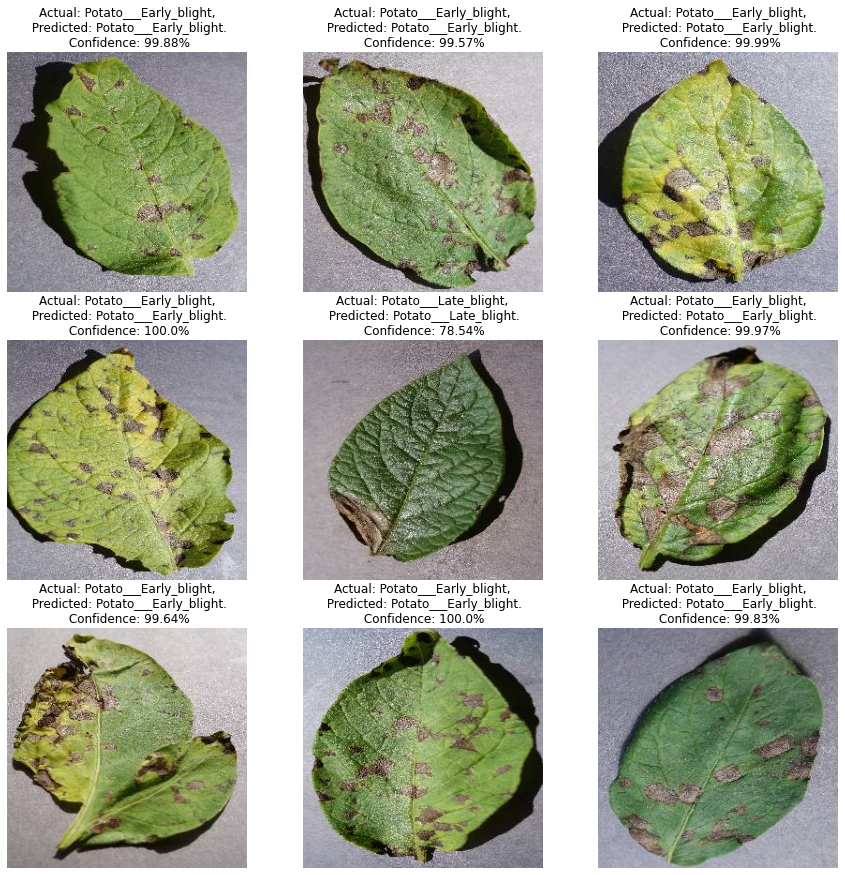

In [37]:
plt.figure(figsize=(15, 15))
for images, label in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(Model, images[i].numpy())
        actual_class = labels[label[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")